# Mixing Density Estimation Experiments
## Testing and Visualization of SemiParametricNVEstimation Algorithm

## 1. Setup and Dependencies

In [18]:
%pip install --quiet tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma, norm, invgamma
from tqdm import tqdm

## 2. Algorithm Implementation

In [20]:
import math
from bisect import bisect_left
from typing import TypedDict, Unpack, Optional, Callable, Dict, List

from numpy import _typing
from scipy.integrate import quad_vec
from scipy.special import gamma

from src.estimators.estimate_result import EstimateResult

GAMMA_DEFAULT_VALUE = 0.25

def u_sequence_default_value(n: float) -> float:
    """Default sequence for u: n^0.25."""
    return n**0.25


def v_sequence_default_value(n: float) -> float:
    """Default sequence for v: log(n)."""
    return math.log(n)


U_SEQUENCE_DEFAULT_VALUE: Callable[[float], float] = u_sequence_default_value
V_SEQUENCE_DEFAULT_VALUE: Callable[[float], float] = v_sequence_default_value
X_DATA_DEFAULT_VALUE: List[float] = [1.0]
GRID_SIZE_DEFAULT_VALUE: int = 200
INTEGRATION_TOLERANCE_DEFAULT_VALUE: float = 1e-2
INTEGRATION_LIMIT_DEFAULT_VALUE: int = 50

class SemiParametricNVEstimation:
    """Estimation of mixing density function g (xi density function) of NV mixture represented in canonical form Y =
    alpha + sqrt(xi)*N, where alpha = 0 and mu = 0.

    Args:
        sample: sample of the analysed distribution
        params: parameters of the algorithm

    """

    class ParamsAnnotation(TypedDict, total=False):
        gmm: float
        u_value: float
        v_value: float
        x_data: List[float]
        grid_size: int
        integration_tolerance: float
        integration_limit: int

    def __init__(self, sample: Optional[_typing.NDArray[np.float64]] = None, **kwargs: Unpack[ParamsAnnotation]):
        self.x_powers: Dict[float, np.ndarray] = {}
        self.second_u_integrals: np.ndarray
        self.first_u_integrals: np.ndarray
        self.gamma_grid: np.ndarray
        self.v_grid: np.ndarray
        self.sample: _typing.NDArray[np.float64] = np.array([]) if sample is None else sample
        self.n: int = len(self.sample)
        (
            self.gmm,
            self.u_value,
            self.v_value,
            self.x_data,
            self.grid_size,
            self.integration_tolerance,
            self.integration_limit,
        ) = self._validate_kwargs(self.n, **kwargs)
        self.denominator: float = 2 * math.pi * self.n
        self.precompute_gamma_grid()
        self.precompute_x_powers()
        self.precompute_u_integrals()

    @staticmethod
    def _validate_kwargs(
        n: int, **kwargs: Unpack[ParamsAnnotation]
    ) -> tuple[float, float, float, List[float], int, float, int]:
        gmm: float = kwargs.get("gmm", GAMMA_DEFAULT_VALUE)
        u_value: float = kwargs.get("u_value", U_SEQUENCE_DEFAULT_VALUE(n))
        v_value: float = kwargs.get("v_value", V_SEQUENCE_DEFAULT_VALUE(n))
        x_data: List[float] = kwargs.get("x_data", X_DATA_DEFAULT_VALUE)
        grid_size: int = kwargs.get("grid_size", GRID_SIZE_DEFAULT_VALUE)
        integration_tolerance: float = kwargs.get("integration_tolerance", INTEGRATION_TOLERANCE_DEFAULT_VALUE)
        integration_limit: int = kwargs.get("integration_limit", INTEGRATION_LIMIT_DEFAULT_VALUE)
        return gmm, u_value, v_value, x_data, grid_size, integration_tolerance, integration_limit

    def conjugate_psi(self, u: float) -> complex:
        return complex((u**2) / 2, 0)  # mu = 0

    def psi(self, u: float) -> complex:
        return complex((u**2) / 2, 0)  # mu = 0

    def precompute_gamma_grid(self) -> None:
        self.v_grid = np.linspace(-self.v_value, self.v_value, self.grid_size)  # Symmetric grid
        gamma_vectorized = np.vectorize(lambda v: gamma(complex(1 - self.gmm, -v)))
        self.gamma_grid = gamma_vectorized(self.v_grid)

    def precompute_x_powers(self) -> None:
        exponents = -self.gmm - 1j * self.v_grid

        for x in self.x_data:
            self.x_powers[x] = np.power(x, exponents)

    def first_u_integrand(self, u: float, v: float) -> np.ndarray:
        expon_factor = np.exp(-1j * u * self.sample)
        conjugate_psi_factor = self.conjugate_psi(u) ** complex(-self.gmm, -v)
        return expon_factor * conjugate_psi_factor

    def second_u_integrand(self, u: float, v: float) -> np.ndarray:
        expon_factor = np.exp(1j * u * self.sample)
        psi_factor = self.psi(u) ** complex(-self.gmm, -v)
        return expon_factor * psi_factor

    def precompute_u_integrals(self) -> None:
        self.first_u_integrals = np.zeros((self.grid_size, self.n), dtype=np.complex_)
        self.second_u_integrals = np.zeros((self.grid_size, self.n), dtype=np.complex_)

        for i, v in enumerate(self.v_grid):
            self.first_u_integrals[i] = quad_vec(
                lambda u: self.first_u_integrand(u, v),
                0,
                self.u_value,
                epsabs=self.integration_tolerance,
                limit=self.integration_limit,
            )[0]

            self.second_u_integrals[i] = quad_vec(
                lambda u: self.second_u_integrand(u, v),
                0,
                self.u_value,
                epsabs=self.integration_tolerance,
                limit=self.integration_limit,
            )[0]

    @staticmethod
    def find_closest_index(grid: np.ndarray, value: float) -> int:
        idx = bisect_left(grid, value)
        if idx == 0:
            return 0
        if idx == len(grid):
            return len(grid) - 1
        before = grid[idx - 1]
        after = grid[idx]
        return idx - 1 if (value - before) < (after - value) else idx

    def first_v_integrand(self, v: float, x: float) -> np.ndarray:
        idx = self.find_closest_index(self.v_grid, v)
        gamma_val = self.gamma_grid[idx]
        x_power = self.x_powers[x][idx]
        return (self.first_u_integrals[idx] * x_power) / gamma_val

    def second_v_integrand(self, v: float, x: float) -> np.ndarray:
        idx = self.find_closest_index(self.v_grid, v)
        gamma_val = self.gamma_grid[idx]
        x_power = self.x_powers[x][idx]
        return (self.second_u_integrals[idx] * x_power) / gamma_val

    def compute_integrals_for_x(self, x: float) -> float:
        first_integral = quad_vec(
            lambda v: self.first_v_integrand(v, x),
            0,
            self.v_value,
            epsabs=self.integration_tolerance,
            limit=self.integration_limit,
        )[0]
        second_integral = quad_vec(
            lambda v: self.second_v_integrand(v, x),
            -self.v_value,
            0,
            epsabs=self.integration_tolerance,
            limit=self.integration_limit,
        )[0]
        total = np.sum(first_integral + second_integral) / self.denominator
        return max(0.0, total.real)

    def algorithm(self, sample: _typing.NDArray[np.float64]) -> EstimateResult:
        y_data = [self.compute_integrals_for_x(x) for x in self.x_data]
        return EstimateResult(list_value=y_data, success=True)

## 3. Test Data Generation

In [21]:
from scipy.stats import gamma as gamma_dist

def generate_test_data(distribution, params, n=1000, mu=0):
    """
    Generates test samples from different mixing distributions.
    
    Parameters:
    - distribution: str, name of the mixing distribution ('exponential', 'gamma', 'invgamma')
    - params: dict, parameters for the distribution
    - n: int, sample size
    - mu: float, mean parameter for the normal variance-mean mixture
    
    Returns:
    - sample: np.ndarray, generated mixture samples
    - true_g: callable, true mixing density function
    """
    if distribution == 'exponential':
        xi = expon(scale=params['scale']).rvs(n)
        true_g = lambda x: expon(scale=params['scale']).pdf(x)
    elif distribution == 'gamma':
        # Gamma distribution requires shape (a) and scale parameters
        xi = gamma_dist(a=params['shape'], scale=params['scale']).rvs(n)
        true_g = lambda x: gamma_dist.pdf(x, a=params['shape'], scale=params['scale'])
    elif distribution == 'invgamma':
        # Inverse gamma distribution requires shape (a) and scale parameters
        xi = invgamma(a=params['shape'], scale=params['scale']).rvs(n)
        true_g = lambda x: invgamma.pdf(x, a=params['shape'], scale=params['scale'])
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    
    # Generate normal variance-mean mixture
    sample = mu * xi + np.sqrt(xi) * norm().rvs(n)
    return sample, true_g

## 4. Visualization Functions

In [22]:
def plot_results(x_values, estimates, true_density, title):
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, estimates, 'bo-', label='Estimated Density')
    plt.plot(x_values, true_density(x_values), 'r--', label='True Density')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_error_analysis(sample_sizes, errors):
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, errors, 'mo-')
    plt.title('Estimation Error vs Sample Size')
    plt.xlabel('Sample Size')
    plt.ylabel('MSE')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

In [23]:
import numpy as np
from scipy.special import rel_entr

# Вычисление метрик
def calculate_metrics(true_g, predicted_values, x_values):
    true_values = true_g(x_values)
    
    # MSE
    mse = np.mean((predicted_values - true_values)**2)
    
    # MAE
    mae = np.mean(np.abs(predicted_values - true_values))
    
    # R-squared
    ss_total = np.sum((true_values - np.mean(true_values))**2)
    ss_residual = np.sum((true_values - predicted_values)**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    # KL-дивергенция
    kl_divergence = np.sum(rel_entr(true_values, predicted_values))
    
    # Max Error
    max_error = np.max(np.abs(predicted_values - true_values))
    
    return {
        "MSE": mse,
        "MAE": mae,
        "R-squared": r_squared,
        "KL Divergence": kl_divergence,
        "Max Error": max_error
    }


## 5. Experiments

### Experiment 1: Basic Functionality Test

#### Exponential

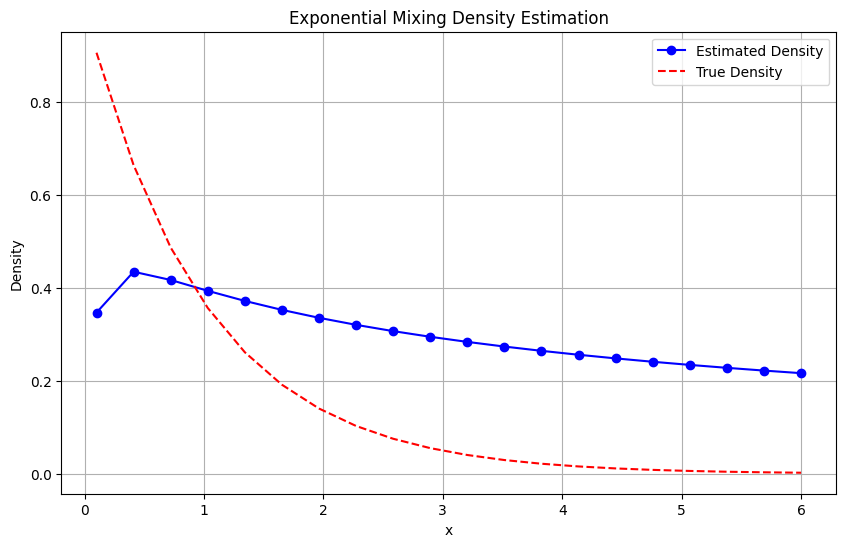

In [24]:
# Generate test data
sample, true_g = generate_test_data('exponential', {'scale': 1}, n=500)

# Setup estimator
x_values = np.linspace(0.1, 6, 20)
estimator = SemiParametricNVEstimation(
    sample,
    x_data=x_values,
    u_value=7.6,
    v_value=0.9,
    grid_size=200)

# Run estimation
result = estimator.algorithm(sample)

# Visualize results
plot_results(x_values, result.list_value, true_g, 
            "Exponential Mixing Density Estimation")

#### Gamma

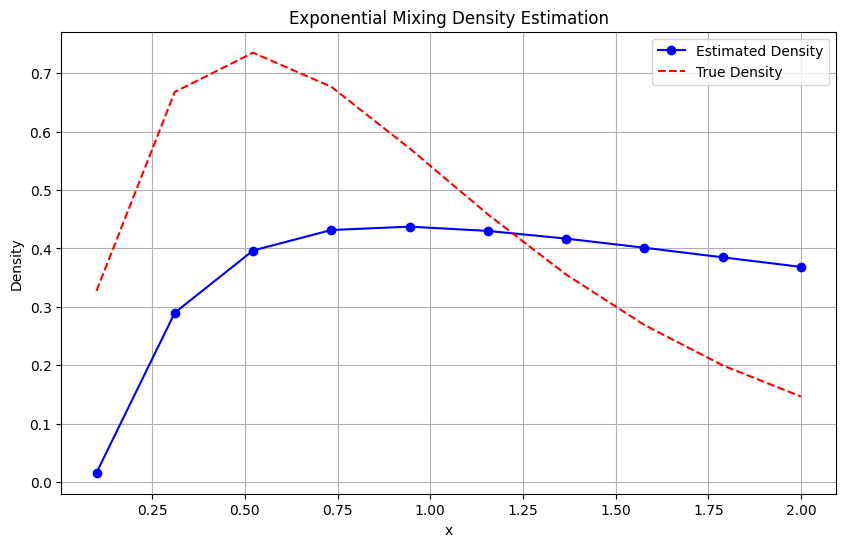

In [25]:
# Generate test data
sample, true_g = generate_test_data('gamma', {'shape': 2, 'scale': 0.5}, n=2000)

# Setup estimator
x_values = np.linspace(0.1, 2, 10)
estimator = SemiParametricNVEstimation(
    sample,
    x_data=x_values,
    u_value=7.6,
    v_value=1.82,
    grid_size=400)

# Run estimation
result = estimator.algorithm(sample)

# Visualize results
plot_results(x_values, result.list_value, true_g, 
            "Exponential Mixing Density Estimation")

In [26]:
metrics = calculate_metrics(true_g, result.list_value, x_values)

# Вывод метрик
print("Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

Metrics:
MSE: 0.0538
MAE: 0.2036
R-squared: -0.3267
KL Divergence: 2.0528
Max Error: 0.3779


#### Inverse Gamma

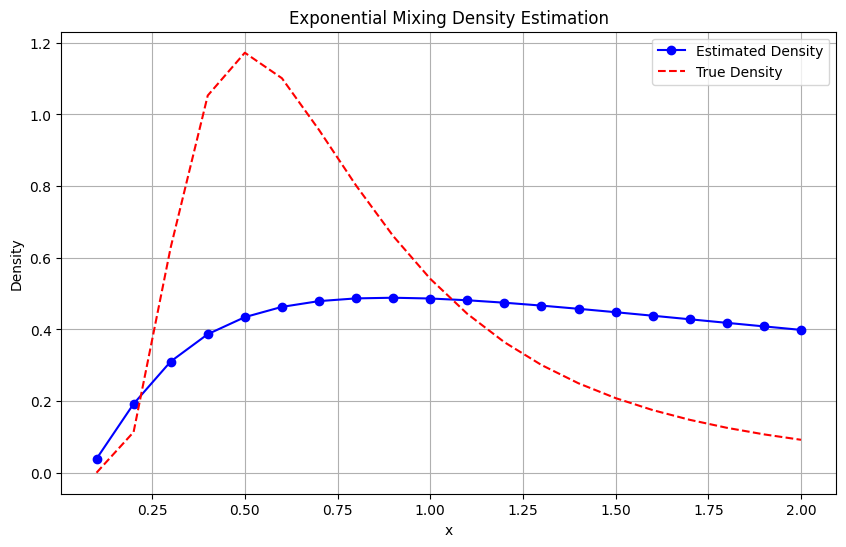

Metrics:
MSE: 0.1213
MAE: 0.2852
R-squared: 0.1127
KL Divergence: 3.5523
Max Error: 0.7379


In [27]:
# Generate test data
sample, true_g = generate_test_data('invgamma', {'shape': 3, 'scale': 2}, n=500)

# Setup estimator
x_values = np.linspace(0.1, 2, 20)
estimator = SemiParametricNVEstimation(
    sample,
    x_data=x_values,
    u_value=7.6,
    v_value=1.82)

# Run estimation
result = estimator.algorithm(sample)

# Visualize results
plot_results(x_values, result.list_value, true_g, 
            "Exponential Mixing Density Estimation")
metrics = calculate_metrics(true_g, result.list_value, x_values)

# Вывод метрик
print("Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")

### Experiment 2: Parameter Sensitivity Analysis

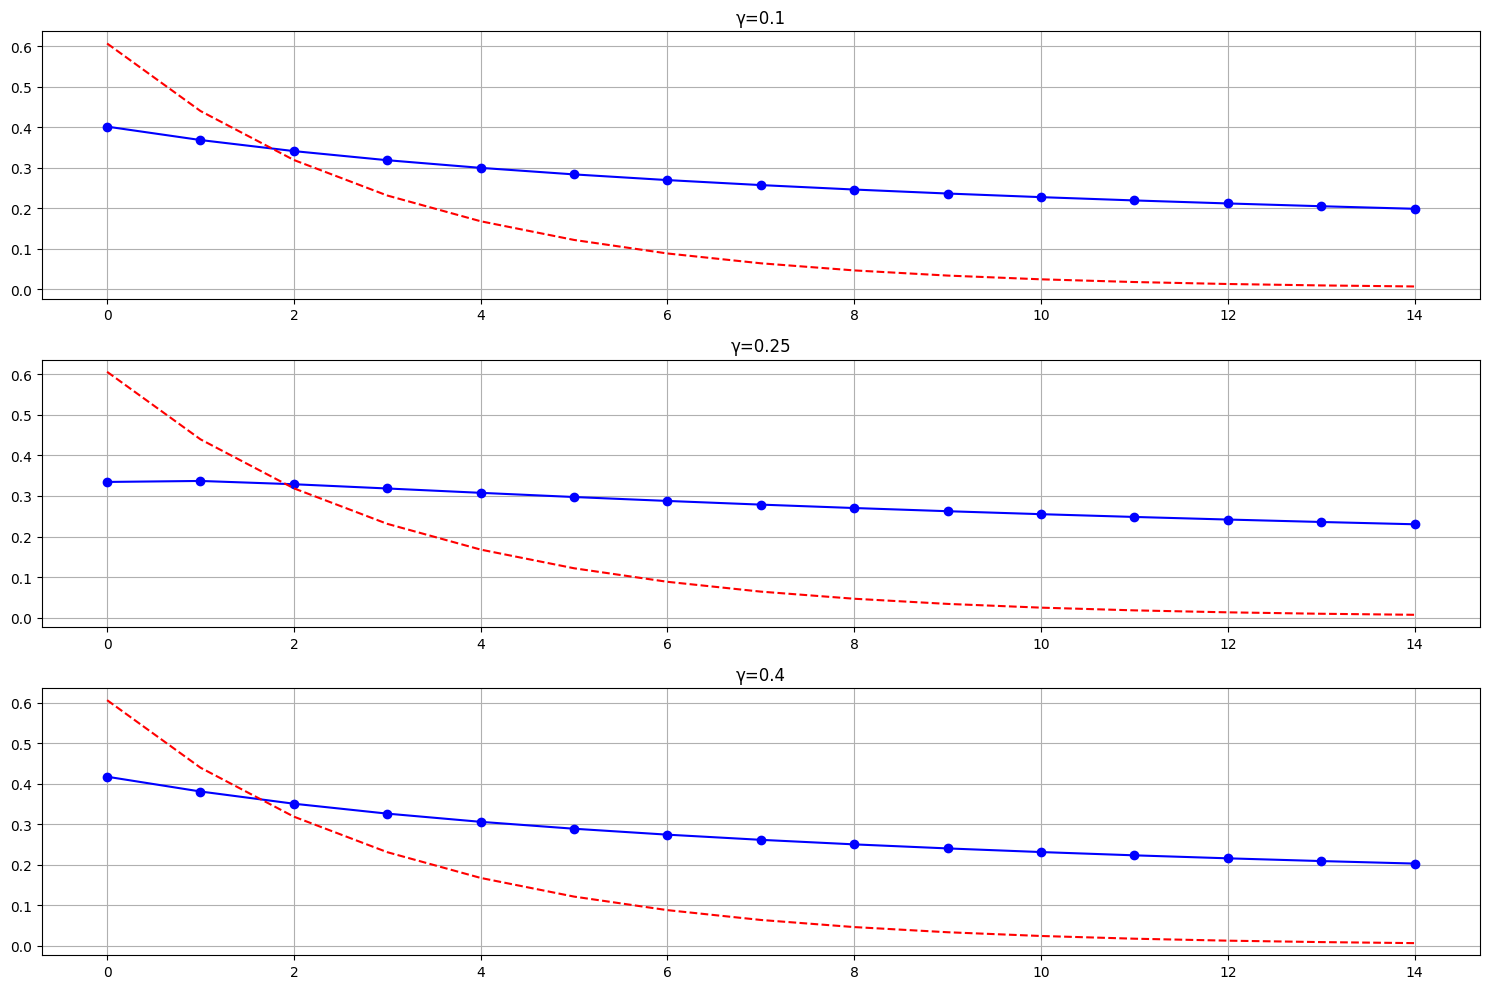

In [28]:
gamma_values = [0.1, 0.25, 0.4]

fig, axes = plt.subplots(len(gamma_values), figsize=(15, 10))

for j, gmm in enumerate(gamma_values):
    sample, true_g = generate_test_data('exponential', {'scale': 1}, n=100)
        
    estimator = SemiParametricNVEstimation(
        sample,
        gmm=gmm,
        x_data=np.linspace(0.5, 5, 15),
        u_value=7.6,
        v_value=0.9)
        
    result = estimator.algorithm(sample)
        
    ax = axes[j]
    ax.plot(result.list_value, 'bo-', label='Estimated')
    ax.plot(true_g(np.linspace(0.5, 5, 15)), 'r--', label='True')
    ax.set_title(f"γ={gmm}")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [29]:
import numpy as np

def bootstrap_confidence_intervals(sample, estimator, x_values, n_bootstrap=100, alpha=0.05):
    """
    Вычисляет бутстреп-доверительные интервалы для оценок плотности.

    Параметры:
    - sample: исходная выборка данных.
    - estimator: объект алгоритма (SemiParametricGEstimationGivenMu).
    - x_values: точки, в которых оценивается плотность.
    - n_bootstrap: количество бутстреп-выборок.
    - alpha: уровень значимости (по умолчанию 0.05 для 95% доверительного интервала).

    Возвращает:
    - ci_lower: нижние границы доверительных интервалов.
    - ci_upper: верхние границы доверительных интервалов.
    """
    bootstrap_estimates = []
    
    for _ in tqdm(range(n_bootstrap)):
        # Генерация бутстреп-выборки
        resample = np.random.choice(sample, size=len(sample), replace=True)
        
        # Оценка плотности для бутстреп-выборки
        estimator_resample = SemiParametricNVEstimation(
            resample,
            x_data=x_values,
            u_value=estimator.u_value,
            v_value=estimator.v_value
        )
        result = estimator_resample.algorithm(resample)
        bootstrap_estimates.append(result.list_value)
    
    # Вычисление квантилей для доверительных интервалов
    ci_lower = np.percentile(bootstrap_estimates, 100 * alpha / 2, axis=0)
    ci_upper = np.percentile(bootstrap_estimates, 100 * (1 - alpha / 2), axis=0)
    
    return ci_lower, ci_upper

100%|██████████| 20/20 [06:11<00:00, 18.58s/it]


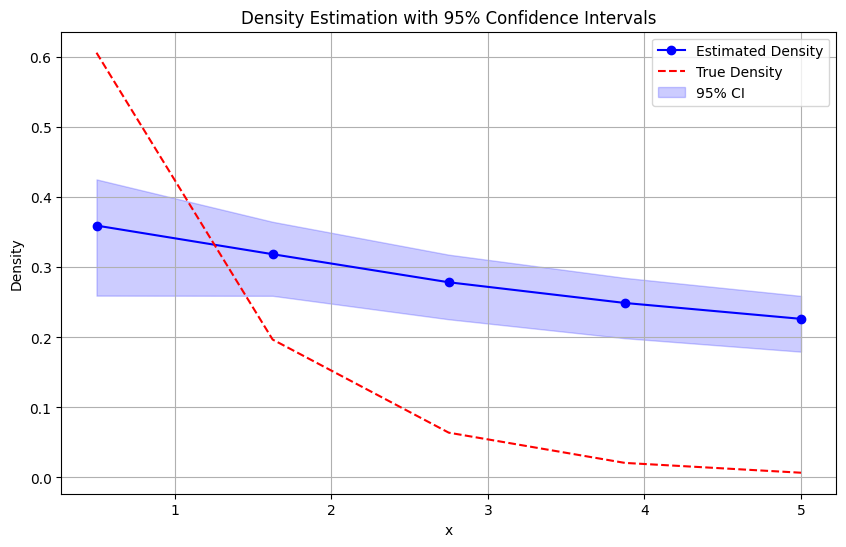

In [30]:
# Генерация тестовых данных
sample, true_g = generate_test_data('exponential', {'scale': 1}, n=100)
x_values = np.linspace(0.5, 5, 5)

# Настройка алгоритма
estimator_given_mu = SemiParametricNVEstimation(
    sample,
    x_data=x_values,
    u_value=7.6,
    v_value=0.9
)

# Оценка плотности
result_given_mu = estimator_given_mu.algorithm(sample)

# Вычисление доверительных интервалов
ci_lower, ci_upper = bootstrap_confidence_intervals(sample, estimator_given_mu, x_values, n_bootstrap=20)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x_values, result_given_mu.list_value, 'bo-', label='Estimated Density')
plt.plot(x_values, true_g(x_values), 'r--', label='True Density')
plt.fill_between(x_values, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.title('Density Estimation with 95% Confidence Intervals')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 10/10 [06:24<00:00, 38.48s/it]


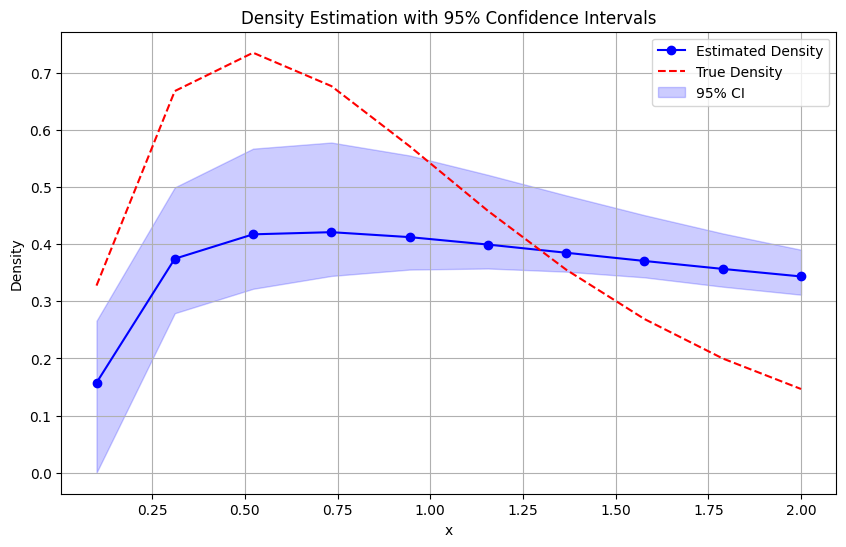

In [31]:
# Generate test data
sample, true_g = generate_test_data('gamma', {'shape': 2, 'scale': 0.5}, n=500)

# Setup estimator
x_values = np.linspace(0.1, 2, 10)
estimator = SemiParametricNVEstimation(
    sample,
    x_data=x_values,
    u_value=7.6,
    v_value=1.82,
    grid_size=400)

# Оценка плотности
result_given_mu = estimator.algorithm(sample)

# Вычисление доверительных интервалов
ci_lower, ci_upper = bootstrap_confidence_intervals(sample, estimator, x_values, n_bootstrap=10)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x_values, result_given_mu.list_value, 'bo-', label='Estimated Density')
plt.plot(x_values, true_g(x_values), 'r--', label='True Density')
plt.fill_between(x_values, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.title('Density Estimation with 95% Confidence Intervals')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 10/10 [07:00<00:00, 42.09s/it]


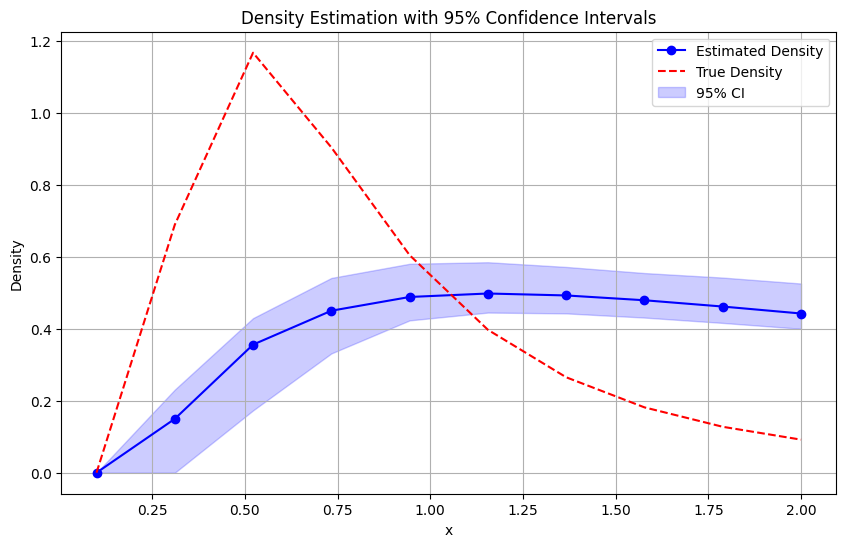

In [32]:
# Generate test data
sample, true_g = generate_test_data('invgamma', {'shape': 3, 'scale': 2}, n=500)

# Setup estimator
x_values = np.linspace(0.1, 2, 10)
estimator = SemiParametricNVEstimation(
    sample,
    x_data=x_values,
    u_value=7.6,
    v_value=1.82,
    grid_size=100)

# Оценка плотности
result_given_mu = estimator.algorithm(sample)

# Вычисление доверительных интервалов
ci_lower, ci_upper = bootstrap_confidence_intervals(sample, estimator, x_values, n_bootstrap=10)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(x_values, result_given_mu.list_value, 'bo-', label='Estimated Density')
plt.plot(x_values, true_g(x_values), 'r--', label='True Density')
plt.fill_between(x_values, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.title('Density Estimation with 95% Confidence Intervals')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()